In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import nltk
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Data Loading and Initial Exploration

In [3]:
# Load datasets
recipes_df = pd.read_csv('/workspaces/Cuisine-Craft/recipes.csv')
reviews_df = pd.read_csv('/workspaces/Cuisine-Craft/reviews.csv')

# Display basic information
print("=== Dataset Information ===")
print("\nRecipes Dataset Shape:", recipes_df.shape)
print("Recipes Dataset Columns:", list(recipes_df.columns))

print("\nReviews Dataset Shape:", reviews_df.shape)
print("Reviews Dataset Columns:", list(reviews_df.columns))

# Display initial data exploration
print("\n=== Recipes Dataset Info ===")
print(recipes_df.info())
print("\nFirst few rows of recipes:")
print(recipes_df.head())
print("\nMissing values in recipes:")
print(recipes_df.isnull().sum())

print("\n=== Reviews Dataset Info ===")
print(reviews_df.info())
print("\nFirst few rows of reviews:")
print(reviews_df.head())
print("\nMissing values in reviews:")
print(reviews_df.isnull().sum())

=== Dataset Information ===

Recipes Dataset Shape: (522517, 28)
Recipes Dataset Columns: ['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime', 'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'RecipeInstructions']

Reviews Dataset Shape: (1401982, 8)
Reviews Dataset Columns: ['ReviewId', 'RecipeId', 'AuthorId', 'AuthorName', 'Rating', 'Review', 'DateSubmitted', 'DateModified']

=== Recipes Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId            

Data Cleaning and Preprocessing

In [4]:
def clean_data(recipes_df, reviews_df):
    """Clean and preprocess both datasets"""
    # Clean recipes data
    recipes_clean = recipes_df.copy()
    
    # Convert time columns to minutes
    def extract_minutes(time_str):
        if pd.isna(time_str):
            return 0
        return int(''.join(filter(str.isdigit, str(time_str))))
    
    print("Converting time columns...")
    recipes_clean['CookMinutes'] = recipes_clean['CookTime'].apply(extract_minutes)
    recipes_clean['PrepMinutes'] = recipes_clean['PrepTime'].apply(extract_minutes)
    recipes_clean['TotalMinutes'] = recipes_clean['TotalTime'].apply(extract_minutes)
    
    # Clean numeric columns
    numeric_cols = ['Calories', 'FatContent', 'SaturatedFatContent', 
                   'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
                   'FiberContent', 'SugarContent', 'ProteinContent']
    
    print("\nCleaning numeric columns...")
    for col in numeric_cols:
        recipes_clean[col] = pd.to_numeric(recipes_clean[col], errors='coerce')
        recipes_clean[col].fillna(recipes_clean[col].median(), inplace=True)
    
    # Clean reviews data
    print("\nCleaning reviews data...")
    reviews_clean = reviews_df.copy()
    reviews_clean['Review'].fillna('', inplace=True)
    
    return recipes_clean, reviews_clean

In [5]:
# Clean the data
recipes_clean, reviews_clean = clean_data(recipes_df, reviews_df)

Converting time columns...

Cleaning numeric columns...

Cleaning reviews data...


In [6]:
# Display cleaned data info
print("\nCleaned Recipes Dataset Info:")
print(recipes_clean.info())


Cleaned Recipes Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-nu

Feature Engineering

In [7]:
def engineer_features(recipes_df, reviews_df):
    """Create new features from existing data"""
    print("\n=== Performing Feature Engineering ===")
    
    recipes_featured = recipes_df.copy()
    
    # 1. Recipe Complexity Features
    print("Creating recipe complexity features...")
    recipes_featured['IngredientCount'] = recipes_featured['RecipeIngredientParts'].apply(
        lambda x: len(str(x).split(',')) if pd.notnull(x) else 0
    )
    
    recipes_featured['InstructionSteps'] = recipes_featured['RecipeInstructions'].apply(
        lambda x: len(str(x).split('.')) if pd.notnull(x) else 0
    )
    
    recipes_featured['ComplexityScore'] = (
        recipes_featured['IngredientCount'] * 0.5 +
        recipes_featured['InstructionSteps'] * 0.3 +
        recipes_featured['TotalMinutes'] * 0.2
    )
    
    # 2. Nutritional Features
    print("Creating nutritional features...")
    recipes_featured['CaloriePerIngredient'] = (
        recipes_featured['Calories'] / recipes_featured['IngredientCount']
    ).fillna(0)
    
    recipes_featured['ProteinToFatRatio'] = (
        recipes_featured['ProteinContent'] / recipes_featured['FatContent']
    ).fillna(0)
    
    # 3. Review Features
    print("Creating review-based features...")
    review_stats = reviews_df.groupby('RecipeId').agg({
        'Rating': ['count', 'mean', 'std'],
        'Review': 'count'
    }).reset_index()
    
    review_stats.columns = ['RecipeId', 'RatingCount', 'AvgRating', 
                          'RatingStd', 'ReviewCount']
    
    recipes_featured = recipes_featured.merge(
        review_stats, on='RecipeId', how='left'
    )
    
    print("\nFeature engineering completed. Sample of new features:")
    new_features = [col for col in recipes_featured.columns 
                   if col not in recipes_df.columns]
    print(recipes_featured[new_features].head())
    
    return recipes_featured

In [8]:
# Create new features
recipes_featured = engineer_features(recipes_clean, reviews_clean)


=== Performing Feature Engineering ===
Creating recipe complexity features...


Creating nutritional features...
Creating review-based features...

Feature engineering completed. Sample of new features:
   ReviewCount_x  IngredientCount  InstructionSteps  ComplexityScore  \
0            4.0                4                14            495.2   
1            1.0               25                17            102.6   
2           10.0                7                 8             12.9   
3            2.0               14                19            496.7   
4           11.0                5                 5             14.0   

   CaloriePerIngredient  ProteinToFatRatio  RatingCount  AvgRating  RatingStd  \
0             42.725000           1.280000          4.0   4.250000   0.500000   
1             44.428000           1.078231          1.0   3.000000        NaN   
2             44.442857           1.500000          9.0   4.333333   1.322876   
3             38.292857           1.220833          2.0   4.500000   0.707107   
4             20.720000          10.750

Descriptive Analytics

In [9]:
def perform_descriptive_analytics(df):
    """Perform descriptive analytics with visualizations"""
    plt.figure(figsize=(15, 10))
    
    # Recipe categories distribution
    plt.subplot(2, 2, 1)
    df['RecipeCategory'].value_counts().head(10).plot(kind='bar')
    plt.title('Top 10 Recipe Categories')
    plt.xticks(rotation=45)
    
    # Rating distribution
    plt.subplot(2, 2, 2)
    sns.histplot(data=df, x='AvgRating', bins=20)
    plt.title('Distribution of Average Ratings')
    
    # Complexity score distribution
    plt.subplot(2, 2, 3)
    sns.histplot(data=df, x='ComplexityScore', bins=50)
    plt.title('Distribution of Recipe Complexity')
    
    # Ingredient count vs Rating
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=df, x='IngredientCount', y='AvgRating')
    plt.title('Ingredient Count vs Average Rating')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    return df.describe()

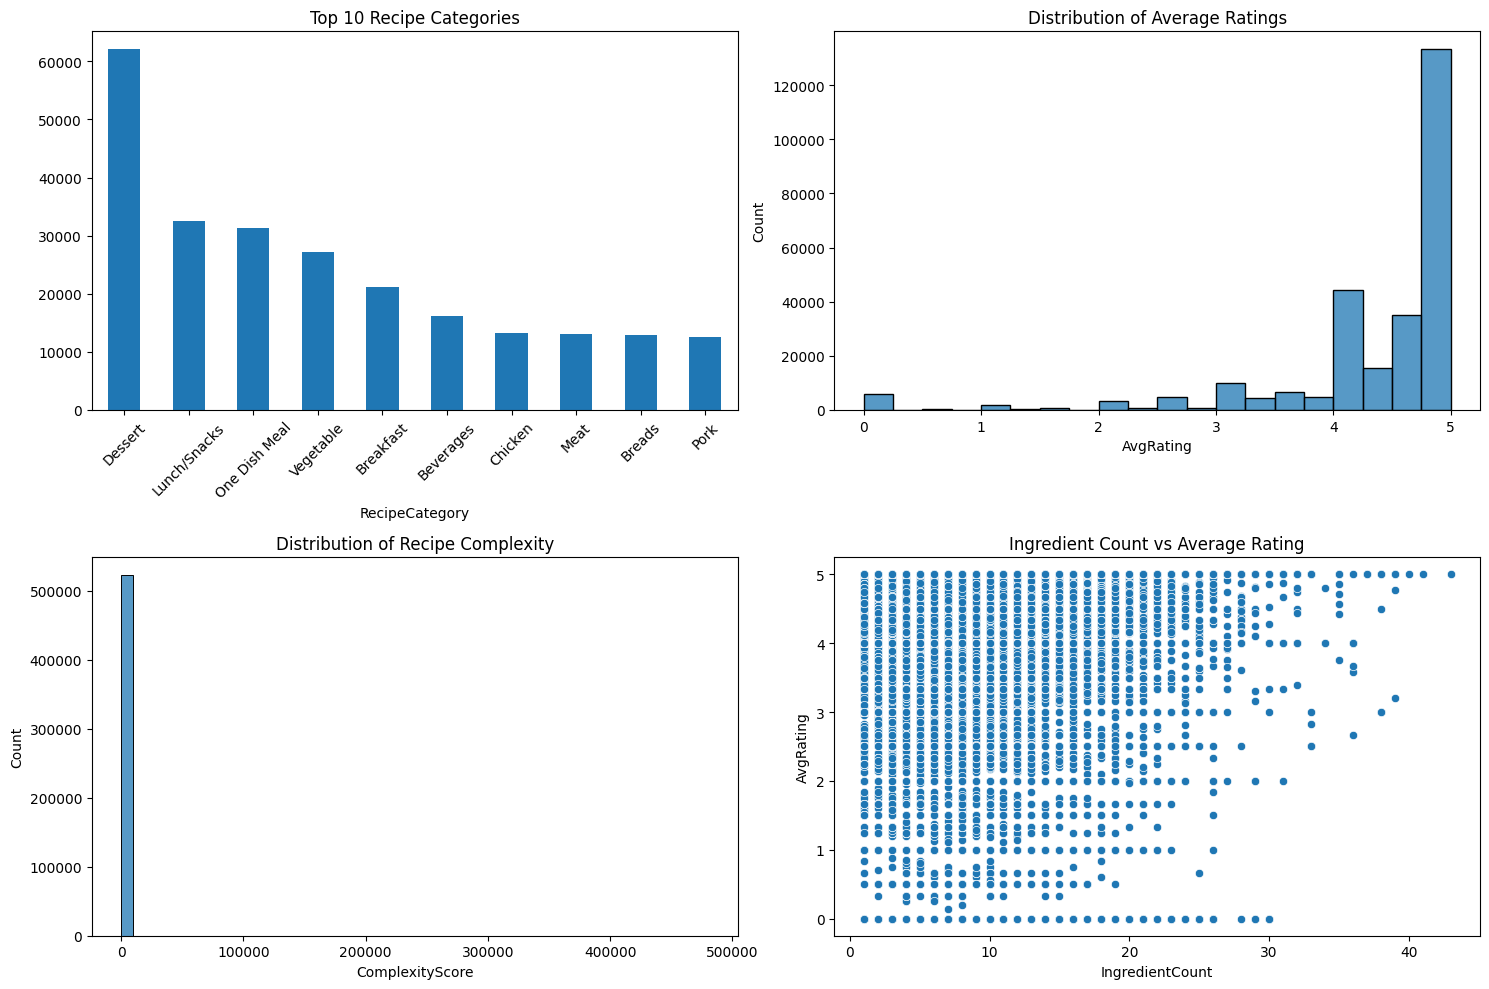


Summary Statistics:
            RecipeId      AuthorId  AggregatedRating  ReviewCount_x  \
count  522517.000000  5.225170e+05     269294.000000  275028.000000   
mean   271821.436970  4.572585e+07          4.632014       5.227784   
std    155495.878422  2.929714e+08          0.641934      20.381347   
min        38.000000  2.700000e+01          1.000000       1.000000   
25%    137206.000000  6.947400e+04          4.500000       1.000000   
50%    271758.000000  2.389370e+05          5.000000       2.000000   
75%    406145.000000  5.658280e+05          5.000000       4.000000   
max    541383.000000  2.002886e+09          5.000000    3063.000000   

            Calories     FatContent  SaturatedFatContent  CholesterolContent  \
count  522517.000000  522517.000000        522517.000000       522517.000000   
mean      484.438580      24.614922             9.559457           86.487003   
std      1397.116649     111.485798            46.622621          301.987009   
min         0.00000

In [10]:
# Perform descriptive analytics
descriptive_stats = perform_descriptive_analytics(recipes_featured)
print(descriptive_stats)

Available columns: ['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime', 'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount_x', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'RecipeInstructions', 'CookMinutes', 'PrepMinutes', 'TotalMinutes', 'IngredientCount', 'InstructionSteps', 'ComplexityScore', 'CaloriePerIngredient', 'ProteinToFatRatio', 'RatingCount', 'AvgRating', 'RatingStd', 'ReviewCount_y']


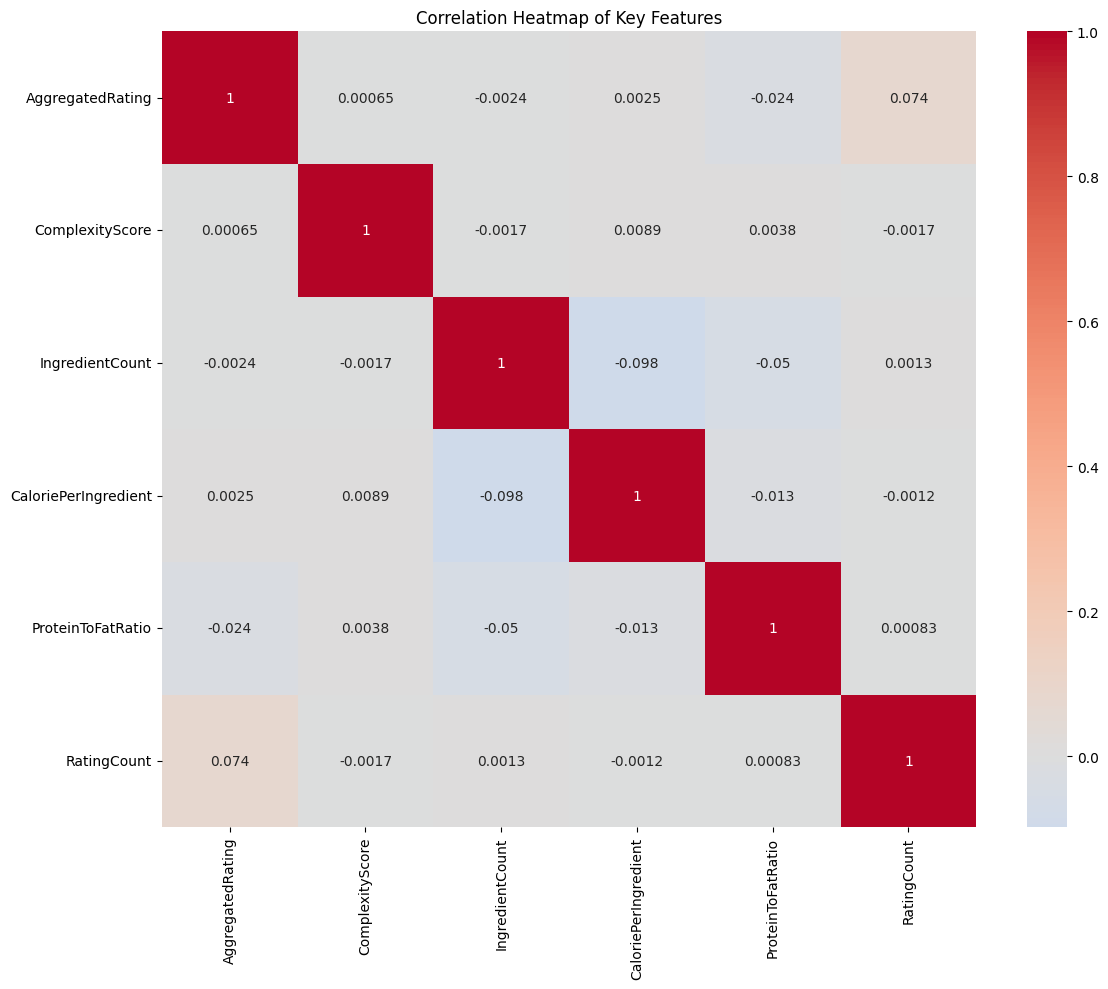

In [11]:
print("Available columns:", list(recipes_featured.columns))

# Modified correlation heatmap code
plt.figure(figsize=(12, 10))

# Update numeric columns based on available columns
numeric_cols = ['AggregatedRating', 'ComplexityScore', 'IngredientCount',
                'CaloriePerIngredient', 'ProteinToFatRatio', 'RatingCount']

# Create correlation heatmap
sns.heatmap(recipes_featured[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.show()

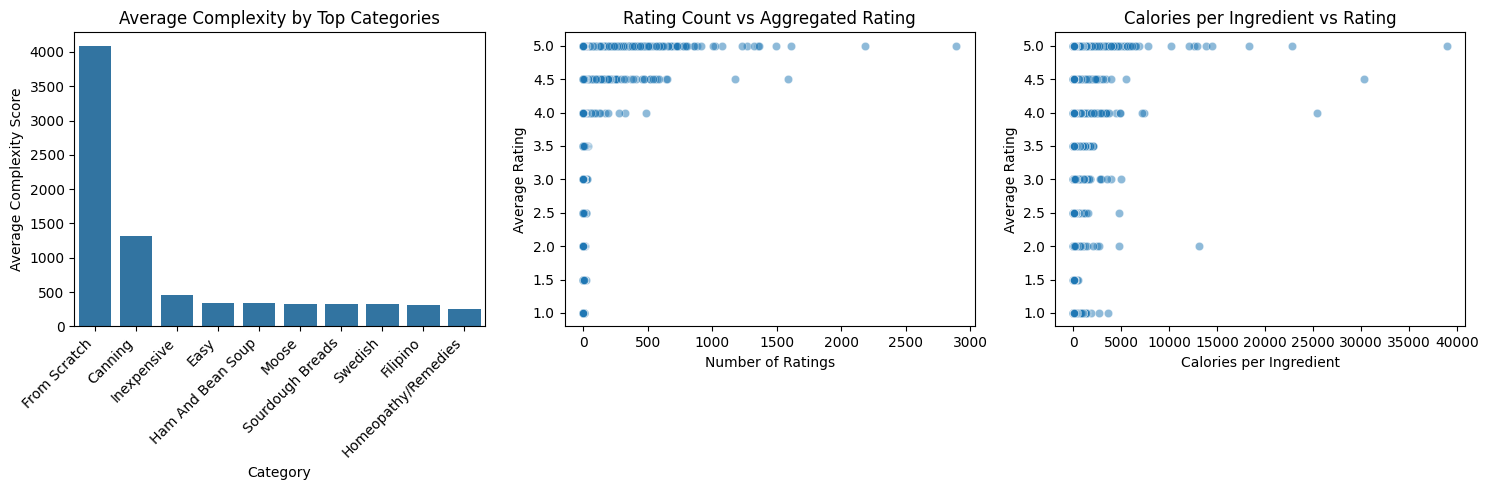

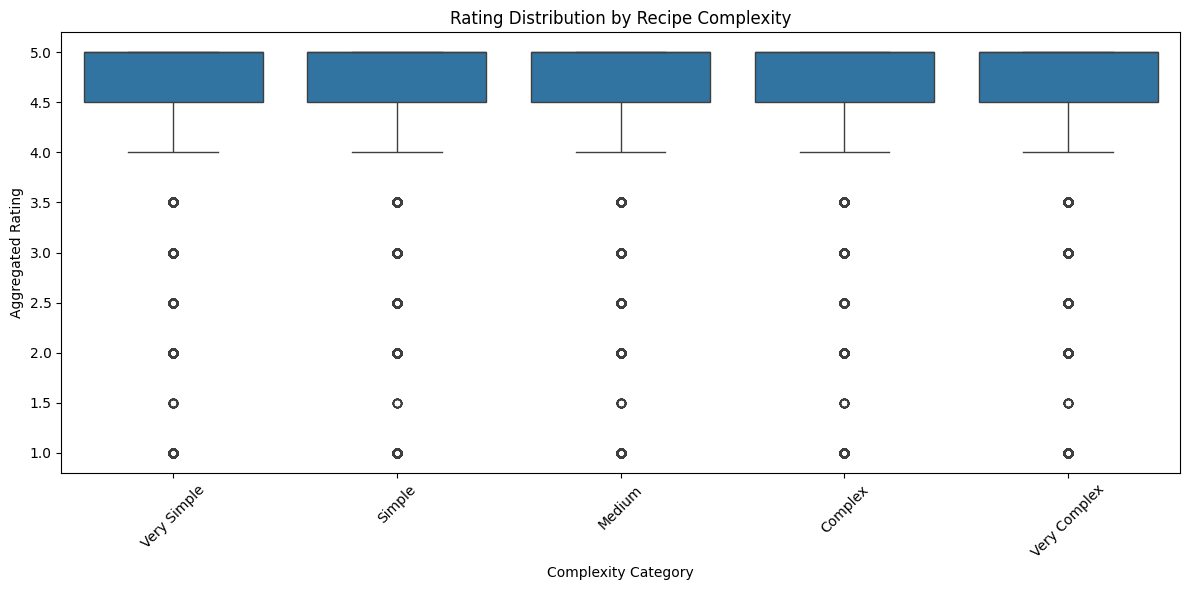


Summary Statistics by Complexity Category:
                      count      mean       std  min  25%  50%  75%  max
ComplexityCategory                                                      
Very Simple         55750.0  4.661040  0.623322  1.0  4.5  5.0  5.0  5.0
Simple              54980.0  4.631957  0.637098  1.0  4.5  5.0  5.0  5.0
Medium              54894.0  4.614402  0.655425  1.0  4.5  5.0  5.0  5.0
Complex             52059.0  4.620824  0.646570  1.0  4.5  5.0  5.0  5.0
Very Complex        51611.0  4.630738  0.646628  1.0  4.5  5.0  5.0  5.0


In [12]:
# Create feature relationship plots
plt.figure(figsize=(15, 5))

# Plot 1: Complexity by Category
plt.subplot(1, 3, 1)
category_data = recipes_featured.groupby('RecipeCategory')['ComplexityScore'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=category_data.index, y=category_data.values)
plt.xticks(rotation=45, ha='right')
plt.title('Average Complexity by Top Categories')
plt.xlabel('Category')
plt.ylabel('Average Complexity Score')

# Plot 2: Rating Count vs Aggregated Rating
plt.subplot(1, 3, 2)
sns.scatterplot(data=recipes_featured, x='RatingCount', y='AggregatedRating', alpha=0.5)
plt.title('Rating Count vs Aggregated Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')

# Plot 3: Calories vs Rating
plt.subplot(1, 3, 3)
sns.scatterplot(data=recipes_featured, x='CaloriePerIngredient', y='AggregatedRating', alpha=0.5)
plt.title('Calories per Ingredient vs Rating')
plt.xlabel('Calories per Ingredient')
plt.ylabel('Average Rating')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Additional relationship visualization - Box plots for ratings by complexity
plt.figure(figsize=(12, 6))
# Create complexity categories
recipes_featured['ComplexityCategory'] = pd.qcut(recipes_featured['ComplexityScore'], 
                                               q=5, 
                                               labels=['Very Simple', 'Simple', 'Medium', 
                                                      'Complex', 'Very Complex'])
sns.boxplot(data=recipes_featured, x='ComplexityCategory', y='AggregatedRating')
plt.title('Rating Distribution by Recipe Complexity')
plt.xticks(rotation=45)
plt.xlabel('Complexity Category')
plt.ylabel('Aggregated Rating')
plt.tight_layout()
plt.show()

# Print summary statistics for these relationships
print("\nSummary Statistics by Complexity Category:")
print(recipes_featured.groupby('ComplexityCategory')['AggregatedRating'].describe())

Sentiment Analysis

In [13]:
# Sentiment analysis on a subset of reviews
print("Performing sentiment analysis on sample...")
# Take a sample of reviews to test
sample_size = 10000
reviews_sample = reviews_clean.sample(n=sample_size, random_state=42)

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment
def get_sentiment(text):
    try:
        return sia.polarity_scores(str(text))['compound']
    except:
        return 0

# Calculate sentiment scores for the sample
reviews_sample['SentimentScore'] = reviews_sample['Review'].apply(get_sentiment)

# Categorize sentiments
reviews_sample['Sentiment'] = reviews_sample['SentimentScore'].apply(
    lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral'
)

# Display sentiment distribution
print("\nSentiment Distribution in Sample:")
sentiment_dist = reviews_sample['Sentiment'].value_counts(normalize=True)
print(sentiment_dist)

Performing sentiment analysis on sample...



Sentiment Distribution in Sample:
Sentiment
Positive    0.9390
Negative    0.0362
Neutral     0.0248
Name: proportion, dtype: float64


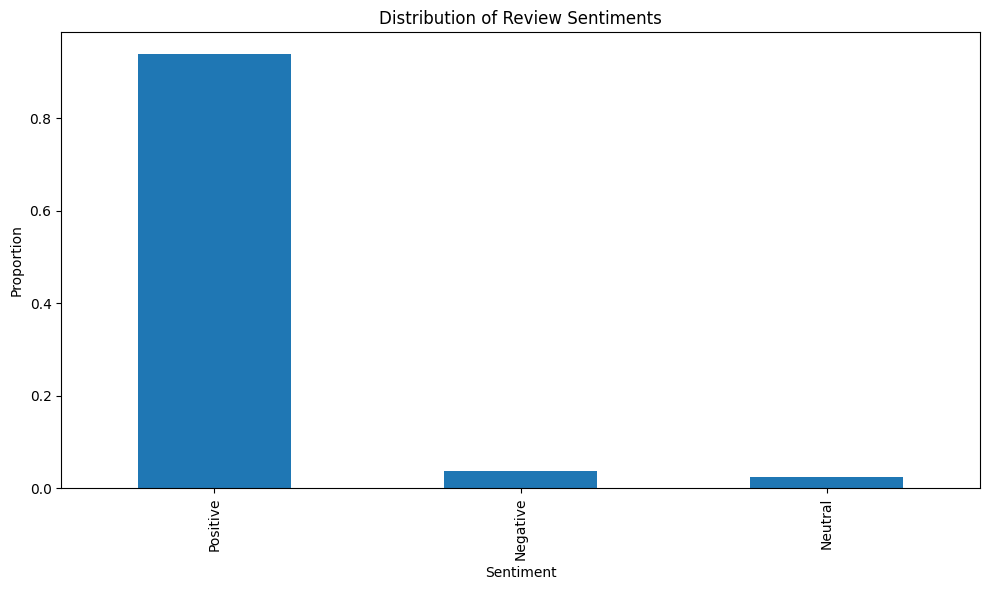

In [14]:
# Bar plot of sentiment distribution
plt.figure(figsize=(10, 6))
sentiment_dist.plot(kind='bar')
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()

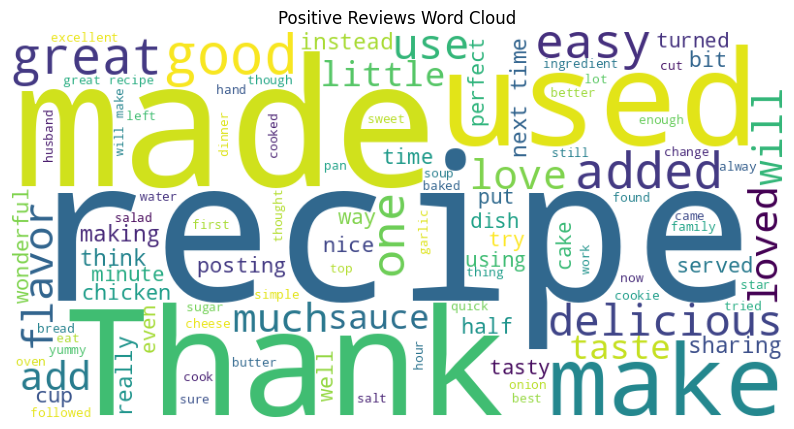

In [15]:
# Word Cloud for Positive Reviews
try:
    # Get positive reviews text
    positive_text = ' '.join(reviews_sample[reviews_sample['Sentiment'] == 'Positive']['Review'])
    
    # Create and display word cloud
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100).generate(positive_text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Positive Reviews Word Cloud')
    plt.show()
except Exception as e:
    print(f"Error creating positive word cloud: {str(e)}")

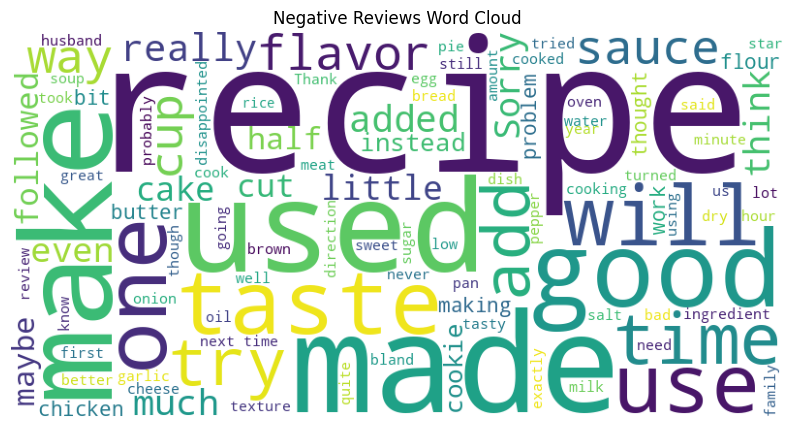

In [16]:
# Word Cloud for Negative Reviews
try:
    # Get negative reviews text
    negative_text = ' '.join(reviews_sample[reviews_sample['Sentiment'] == 'Negative']['Review'])
    
    # Create and display word cloud
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100).generate(negative_text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Negative Reviews Word Cloud')
    plt.show()
except Exception as e:
    print(f"Error creating negative word cloud: {str(e)}")

In [17]:
# Sentiment statistics
print("\nSentiment Score Statistics:")
print(reviews_sample['SentimentScore'].describe())

# Most positive and negative reviews examples
print("\nExample of Most Positive Review:")
most_positive = reviews_sample.loc[reviews_sample['SentimentScore'].idxmax()]
print(f"Score: {most_positive['SentimentScore']:.3f}")
print(f"Review: {most_positive['Review'][:200]}...")

print("\nExample of Most Negative Review:")
most_negative = reviews_sample.loc[reviews_sample['SentimentScore'].idxmin()]
print(f"Score: {most_negative['SentimentScore']:.3f}")
print(f"Review: {most_negative['Review'][:200]}...")


Sentiment Score Statistics:
count    10000.000000
mean         0.759754
std          0.314455
min         -0.965100
25%          0.724900
50%          0.881900
75%          0.943100
max          0.998100
Name: SentimentScore, dtype: float64

Example of Most Positive Review:
Score: 0.998
Review: YES YES YES!!!!! A few things to note... I used closer to 3/4 of an orange zest (an orange with a very thick peel). Felt that was overpowering. I would say that 1/4 of the orange (or even a bit less a...

Example of Most Negative Review:
Score: -0.965
Review: The cookie part was good. But the frosting.. ALL but 2 of my kids pulled the frosting off. They didn't like it. The cookie base has more of an oatmeal cookie flavor, NO lemon flavor in the cookie part...


Predictive Analytics

In [18]:
print("Available columns in dataset:")
print(recipes_featured.columns)

Available columns in dataset:
Index(['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'CookTime', 'PrepTime',
       'TotalTime', 'DatePublished', 'Description', 'Images', 'RecipeCategory',
       'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts',
       'AggregatedRating', 'ReviewCount_x', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeYield', 'RecipeInstructions', 'CookMinutes',
       'PrepMinutes', 'TotalMinutes', 'IngredientCount', 'InstructionSteps',
       'ComplexityScore', 'CaloriePerIngredient', 'ProteinToFatRatio',
       'RatingCount', 'AvgRating', 'RatingStd', 'ReviewCount_y',
       'ComplexityCategory'],
      dtype='object')


In [19]:
def build_prediction_model(df):
    features = ['ComplexityScore', 'IngredientCount', 'TotalMinutes', 
                'CaloriePerIngredient', 'ProteinToFatRatio', 'RatingCount']
    
    # Create copy and handle infinite values
    model_df = df.copy()
    model_df = model_df.replace([np.inf, -np.inf], np.nan)
    model_df = model_df.dropna(subset=features + ['AggregatedRating'])
    
    # Replace remaining extreme values
    for col in features:
        q1 = model_df[col].quantile(0.01)
        q3 = model_df[col].quantile(0.99)
        model_df[col] = model_df[col].clip(q1, q3)
    
    X = model_df[features]
    y = model_df['AggregatedRating']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance in Predicting Recipe Ratings')
    plt.show()
    
    return {'mse': mse, 'r2': r2, 'feature_importance': feature_importance}

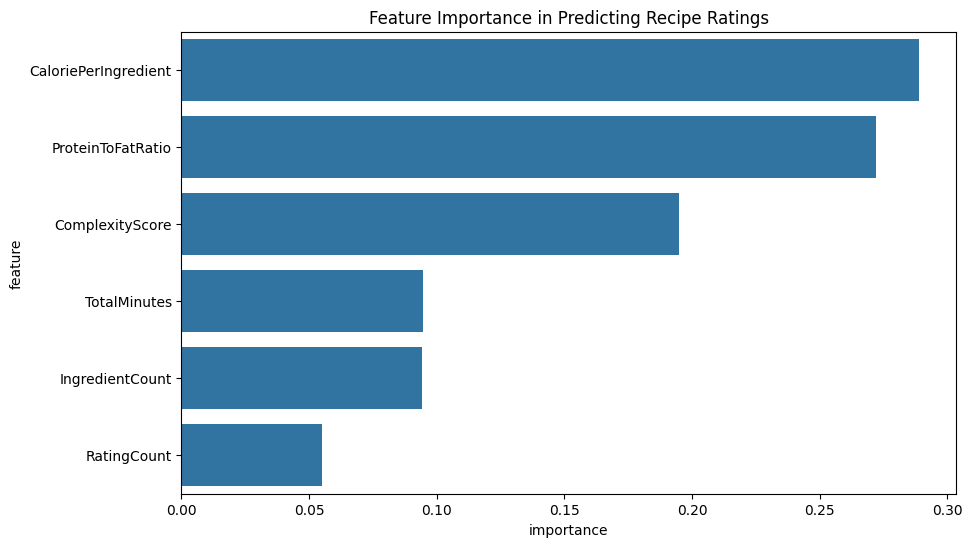

Mean Squared Error: 0.4095
R-squared Score: -0.0111


In [20]:
model_results = build_prediction_model(recipes_featured)
print(f"Mean Squared Error: {model_results['mse']:.4f}")
print(f"R-squared Score: {model_results['r2']:.4f}")